## Imports

In [0]:
import re, sys, math, logging
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from matplotlib import pyplot as plt
print("Tensorflow version " + tf.__version__)
tf.get_logger().setLevel(logging.ERROR)

Tensorflow version 2.2.0-dlenv


## TPU or GPU detection
TPUClusterResolver() automatically detects a connected TPU on all Gooogle's
platforms: Colaboratory, AI Platform (ML Engine), Kubernetes and Deep Learning
VMs provided the TPU_NAME environment variable is set on the VM.

In [0]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.MirroredStrategy() # works on GPU and multi-GPU
    policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
    tf.config.optimizer.set_jit(True) # XLA compilation
    tf.keras.mixed_precision.experimental.set_policy(policy)
    print('Mixed precision enabled')

print("REPLICAS: ", strategy.num_replicas_in_sync)

# mixed precision
# On TPU, bfloat16/float32 mixed precision is automatically used in TPU computations.
# Enabling it in Keras also stores relevant variables in bfloat16 format (memory optimization).
# This additional optimization was not used for TPUs in this sample.
# On GPU, specifically V100, mixed precision must be enabled for hardware TensorCores to be used.
# XLA compilation must be enabled for this to work. (On TPU, XLA compilation is the default and cannot be turned off)

REPLICAS:  8


## Configuration

Learning rate schedule:


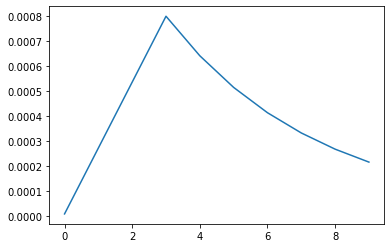

In [0]:
#GCS_DS_PATH = 'gs://one-hundred-flowers-public-euwest'
GCS_DS_PATH = 'gs://one-hundred-flowers-public' # USA

IMAGE_SIZE = [512, 512]
EPOCHS = 10

if tpu:
    BATCH_SIZE = 32 * strategy.num_replicas_in_sync
else:
    BATCH_SIZE = 4 * strategy.num_replicas_in_sync

GCS_PATH_SELECT = { # available image sizes
    192: GCS_DS_PATH + '/tfrecords-jpeg-192x192',
    224: GCS_DS_PATH + '/tfrecords-jpeg-224x224',
    331: GCS_DS_PATH + '/tfrecords-jpeg-331x331',
    512: GCS_DS_PATH + '/tfrecords-jpeg-512x512'
}
GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec')

CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102

AUTO = tf.data.experimental.AUTOTUNE

# Learning rate settings
if strategy.num_replicas_in_sync > 8:
    # settings for TPUv3-32
    LR_MAX = 0.00006 * strategy.num_replicas_in_sync
    LR_RAMPUP_EPOCHS = 3
    LR_EXP_DECAY = .75
elif strategy.num_replicas_in_sync == 4:
    # settings for 4xV100
    LR_MAX = 0.0001 * strategy.num_replicas_in_sync
    LR_RAMPUP_EPOCHS = 4
    LR_EXP_DECAY = .8
else:
    # settings for TPUv3-8, V100, 8xV100
    LR_MAX = 0.0001 * strategy.num_replicas_in_sync
    LR_RAMPUP_EPOCHS = 3
    LR_EXP_DECAY = .8
LR_START = 0.00001
LR_MIN = 0.00001
LR_SUSTAIN_EPOCHS = 0

@tf.function
def lr_fn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr

print("Learning rate schedule:")
rng = [i for i in range(EPOCHS)]
y = [lr_fn(x) for x in rng]
plt.plot(rng, [lr_fn(x) for x in rng])
plt.show()

## Display utilities

In [0]:
# numpy and matplotlib defaults
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    if type(data) == tuple:
        images, labels = data
        numpy_labels = labels.numpy()
    else:
        images = data
        numpy_labels = None
    numpy_images = images.numpy()
    if numpy_labels is None or numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    #plt.tight_layout() ## buggy in this version of matplotlib ##
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()
    
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        #plt.tight_layout()  ## buggy in this version of matplotlib ##
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

## Dataset

In [0]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def data_augment(image, label):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    #image = tf.image.random_saturation(image, 0, 2)
    return image, label   

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 12753 training images, 3712 validation images, 7382 unlabeled test images


In [0]:
# Peek at training data
training_dataset = get_training_dataset()
training_dataset = training_dataset.unbatch().batch(20)
train_batch = iter(training_dataset)

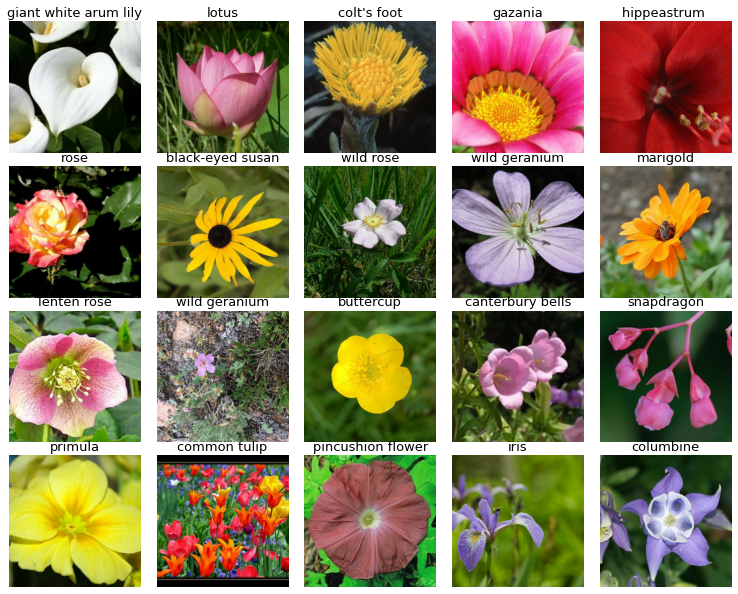

In [0]:
# run this cell again for next set of images
display_batch_of_images(next(train_batch))

## Model

In [0]:
%%time
with strategy.scope():
    if tpu:
        # this works on both TPU and GPU
        pretrained_model = tf.saved_model.load('gs://efficientnet_b6_pub') # same model as 'https://tfhub.dev/tensorflow/efficientnet/b6/feature-vector/1'
        pretrained_model = hub.KerasLayer(pretrained_model, trainable=True, input_shape=[*IMAGE_SIZE, 3], dtype=tf.float32) # float32 here so that mixed precision works
    else:
        # this way of loading is much faster but does not work on TPU
        pretrained_model = hub.KerasLayer('https://tfhub.dev/tensorflow/efficientnet/b6/feature-vector/1', trainable=True, input_shape=[*IMAGE_SIZE, 3], dtype=tf.float32) # float32 here so that mixed precision works
    
    # this shorter version also works in GCP, but not on Colab (?)
    #pretrained_model = hub.KerasLayer('gs://efficientnet_b6_pub', trainable=True, input_shape=[*IMAGE_SIZE, 3], dtype=tf.float32)
    
    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.Dense(len(CLASSES), activation='softmax', dtype=tf.float32)  # float32 here so that mixed precision works
    ])
        
    model.compile(
        optimizer='adam',
        loss = 'sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )
    
    model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2304)              40960136  
_________________________________________________________________
dense (Dense)                (None, 104)               239720    
Total params: 41,199,856
Trainable params: 40,975,424
Non-trainable params: 224,432
_________________________________________________________________
CPU times: user 46.6 s, sys: 5.25 s, total: 51.8 s
Wall time: 50.8 s


## Training

In [0]:
%%time
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_fn)
history = model.fit(get_training_dataset(), steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS,
                    #validation_data=get_validation_dataset(),
                    callbacks=[lr_callback])

Epoch 1/10
49/49 [==============================] - 64s 1s/step - loss: 4.9267 - sparse_categorical_accuracy: 0.0372 - lr: 1.0000e-05
Epoch 2/10
49/49 [==============================] - 65s 1s/step - loss: 2.7383 - sparse_categorical_accuracy: 0.5276 - lr: 2.7333e-04
Epoch 3/10
49/49 [==============================] - 65s 1s/step - loss: 0.8996 - sparse_categorical_accuracy: 0.8705 - lr: 5.3667e-04
Epoch 4/10
49/49 [==============================] - 65s 1s/step - loss: 0.6259 - sparse_categorical_accuracy: 0.9304 - lr: 8.0000e-04
Epoch 5/10
49/49 [==============================] - 65s 1s/step - loss: 0.5079 - sparse_categorical_accuracy: 0.9601 - lr: 6.4200e-04
Epoch 6/10
49/49 [==============================] - 65s 1s/step - loss: 0.4339 - sparse_categorical_accuracy: 0.9793 - lr: 5.1560e-04
Epoch 7/10
49/49 [==============================] - 65s 1s/step - loss: 0.3963 - sparse_categorical_accuracy: 0.9895 - lr: 4.1448e-04
Epoch 8/10
49/49 [==============================] - 65s 1s/ste

In [0]:
#display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211)
#display_training_curves(history.history['sparse_categorical_accuracy'], history.history['val_sparse_categorical_accuracy'], 'accuracy', 212)

## Confusion matrix

In [0]:
cmdataset = get_validation_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and labels, order matters.
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()
cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy() # get everything as one batch
images_ds = images_ds.unbatch().batch(128) # bug on TPU v3-32, predictions won't work without this
cm_probabilities = model.predict(images_ds)
cm_predictions = np.argmax(cm_probabilities, axis=-1)
print("Correct   labels: ", cm_correct_labels.shape, cm_correct_labels)
print("Predicted labels: ", cm_predictions.shape, cm_predictions)

Correct   labels:  (3712,) [ 50  13  74 ... 102  48  67]
Predicted labels:  (3712,) [ 50  13  74 ... 102  48  67]


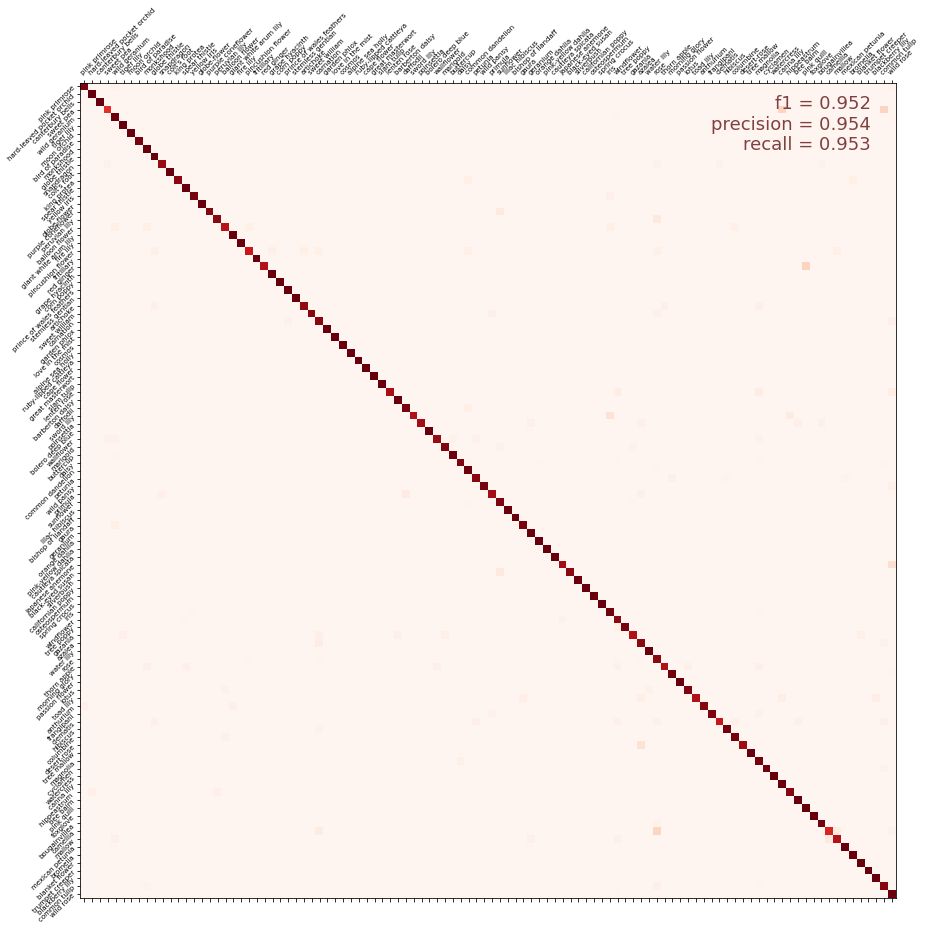

f1 score: 0.952, precision: 0.954, recall: 0.953


In [0]:
cmat = confusion_matrix(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)))
score = f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
precision = precision_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
recall = recall_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
cmat = (cmat.T / cmat.sum(axis=1)).T # normalized
display_confusion_matrix(cmat, score, precision, recall)
print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall))

## Visual validation

In [0]:
dataset = get_validation_dataset()
dataset = dataset.unbatch().batch(20)
batch = iter(dataset)

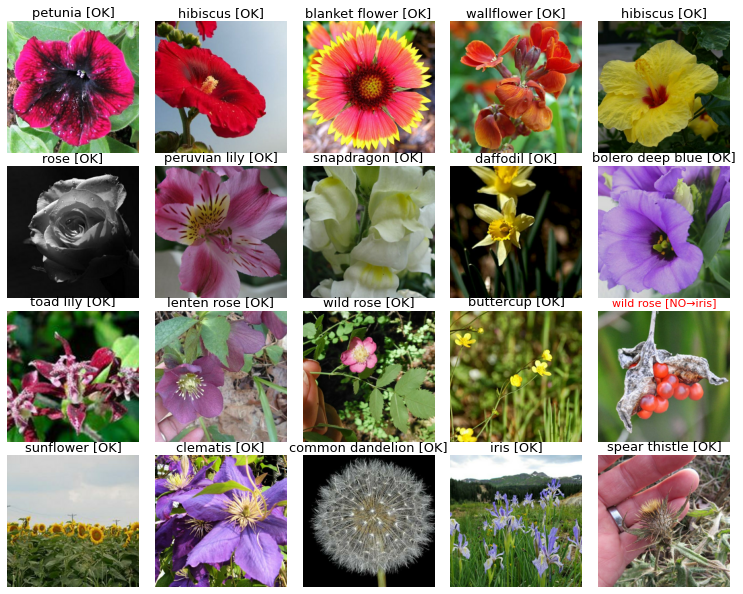

In [0]:
# run this cell again for next set of images
images, labels = next(batch)
probabilities = model.predict(images)
predictions = np.argmax(probabilities, axis=-1)
display_batch_of_images((images, labels), predictions)

## License



---


author: Martin Gorner<br>
twitter: @martin_gorner


---


Copyright 2020 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


---


This is not an official Google product but sample code provided for an educational purpose
